In [128]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
import os
import numpy as np
import matplotlib.pyplot as plt

In [130]:
# Load data
def load_HAR_data():
    data_dir = '/Users/thomas.greiner/Desktop/Data/Files/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test = np.load(os.path.join(data_dir, 'y_test.npy')) - 1 
    return (x_train, y_train), (x_test, y_test)

label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 
                     2: 'walking downstairs', 3: 'sitting', 4: 'standing',
                     5: 'laying'}

def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max() + 1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

In [131]:
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

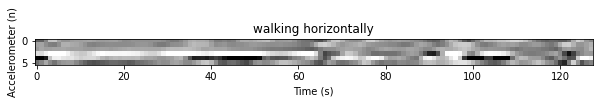

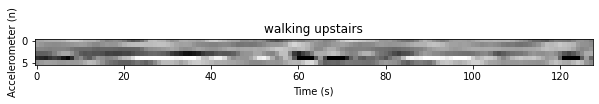

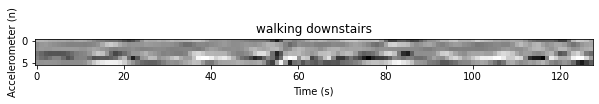

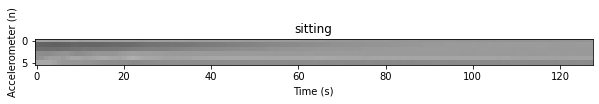

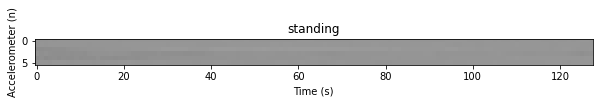

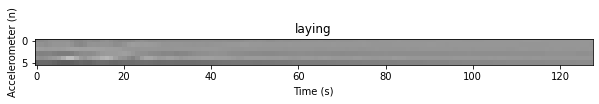

In [132]:
def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            #ax.axis('off')
            ax.set_ylabel('Accelerometer (n)')
            ax.set_xlabel('Time (s)')
            if i ==0:
                ax.set_title(label_to_activity[label])
                plt.show()

make_plots(1)

### lets do some convolutions on these data

In [279]:
# deterministic 1D convolutional neural network
model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPool1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 113, 8)            776       
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 7, 8)             0         
 g1D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 56)                0         
                                                                 
 dense_13 (Dense)            (None, 6)                 342       
                                                                 
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


In [247]:
# stochastic 1D convolutional neural network

divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]

model_prob = Sequential([
    tfpl.Convolution1DReparameterization(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu',
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn, #
                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         kernel_divergence_fn=divergence_fn,
                                         bias_prior_fn=tfpl.default_multivariate_normal_fn,
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         bias_divergence_fn=divergence_fn),
    MaxPool1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(6), activation='relu',
                                 kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                 kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                 kernel_divergence_fn=divergence_fn,
                                 bias_prior_fn=tfpl.default_multivariate_normal_fn,
                                 bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                 bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)
])
model_prob.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_reparameterization_1  (None, 113, 8)           1552      
 0 (Conv1DReparameterization                                     
 )                                                               
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 7, 8)             0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 56)                0         
                                                                 
 dense_reparameterization_4   (None, 6)                684       
 (DenseReparameterization)                                       
                                                                 
 one_hot_categorical_6 (OneH  ((None, 6),            

/Users/thomas.greiner/miniforge3/envs/tensorflow-gpu/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/thomas.greiner/miniforge3/envs/tensorflow-gpu/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [56]:
# if the two, or one of the two distributions are not known, i.e., known analytically, we can approximate the KL divergence by the monte carlo estimate

def kl_approx(q, p, q_tensor):
    return  tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [257]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_prob.compile(loss=nll, 
                   optimizer=RMSprop(learning_rate=0.005), 
                   metrics=['accuracy'], 
                   experimental_run_tf_function=False)

In [280]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=RMSprop(learning_rate=0.005), 
              metrics=['accuracy'])

In [268]:
model_prob.fit(x_train, y_train_oh, epochs=150, verbose='auto')

Epoch 1/150
230/230 [==============================] - 0s 2ms/step - loss: 0.5722 - accuracy: 0.8186
Epoch 2/150
230/230 [==============================] - 0s 1ms/step - loss: 0.6082 - accuracy: 0.8184
Epoch 3/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.8191
Epoch 4/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.8186
Epoch 5/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.8226
Epoch 6/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5883 - accuracy: 0.8186
Epoch 7/150
230/230 [==============================] - 0s 1ms/step - loss: 0.6056 - accuracy: 0.8130
Epoch 8/150
230/230 [==============================] - 0s 1ms/step - loss: 0.6030 - accuracy: 0.8154
Epoch 9/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5773 - accuracy: 0.8146
Epoch 10/150
230/230 [==============================] - 0s 1ms/step - loss: 0.5888 - accura

In [285]:
model.fit(x_train, y_train, epochs=500, verbose='auto')


Epoch 1/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2452 - accuracy: 0.9253
Epoch 2/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.9241
Epoch 3/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2433 - accuracy: 0.9275
Epoch 4/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2340 - accuracy: 0.9257
Epoch 5/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2360 - accuracy: 0.9251
Epoch 6/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2372 - accuracy: 0.9287
Epoch 7/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2357 - accuracy: 0.9297
Epoch 8/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2391 - accuracy: 0.9279
Epoch 9/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2303 - accuracy: 0.9300
Epoch 10/500
230/230 [==============================] - 0s 1ms/step - loss: 0.2306 - accura

In [244]:
# Define function to analyse model predictions versus true labels
def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted = model(x_test[image_num:image_num+1])
    print( tf.nn.softmax(predicted) )
    predicted = tf.nn.softmax(predicted).numpy()[0]
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), predicted, color='red')
    bar = ax.bar(np.arange(6), predicted-0.02, color='white')    
    plt.text(0, 1.1, 'Correct label: ' + label_to_activity[y_test[image_num, 0]])

    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                        rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

In [254]:

def analyse_model_predictions_prob(image_num):

    # Show the accelerometer data
    # print('------------------------------')
    # print('Accelerometer data:')
    # fig, ax = plt.subplots(figsize=(10, 1))
    # ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    # ax.axis('off')
    # plt.show()

    # # Print the true activity
    # print('------------------------------')
    # print('True activity:', label_to_activity[y_test[image_num, 0]])
    # print('')

    # # Print the probabilities the model assigns
    # print('------------------------------')
    # print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model_prob(x_test[image_num:image_num+1]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


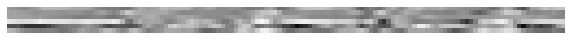

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:
tf.Tensor(
[[1.0000000e+00 6.4478064e-28 7.9137395e-36 0.0000000e+00 0.0000000e+00
  0.0000000e+00]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


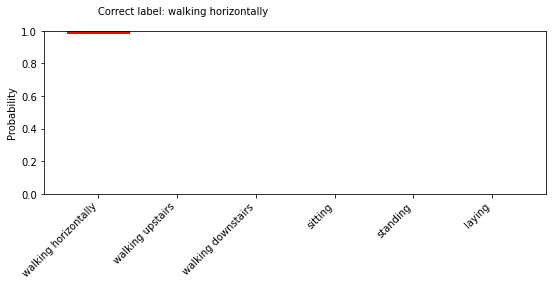

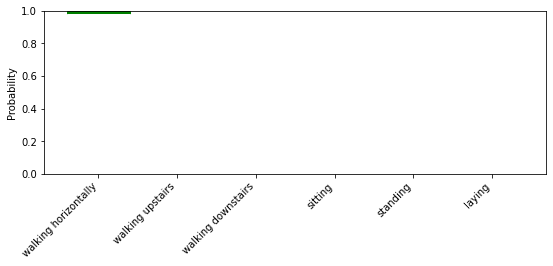

In [269]:
analyse_model_predictions(image_num=79)
analyse_model_predictions_prob(image_num=79)

------------------------------
Accelerometer data:


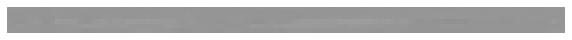

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:
tf.Tensor(
[[8.1312856e-21 2.5006216e-20 5.6053825e-24 3.7833130e-01 5.9479469e-01
  2.6873993e-02]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


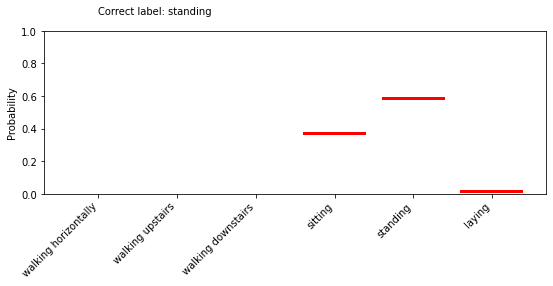

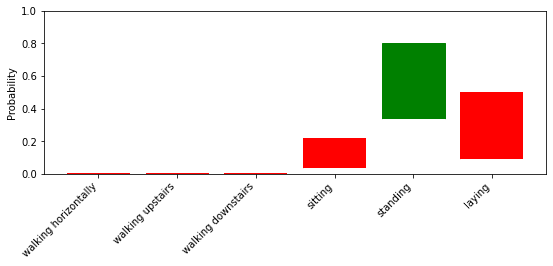

In [270]:
analyse_model_predictions(image_num=633)
analyse_model_predictions_prob(image_num=633)

------------------------------
Accelerometer data:


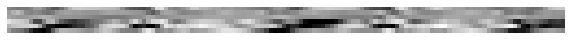

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:
tf.Tensor(
[[1.0000000e+00 3.0237934e-11 5.7677653e-08 0.0000000e+00 0.0000000e+00
  0.0000000e+00]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


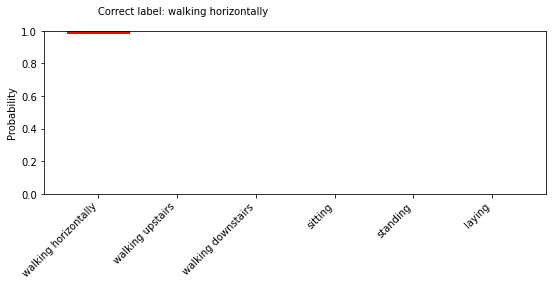

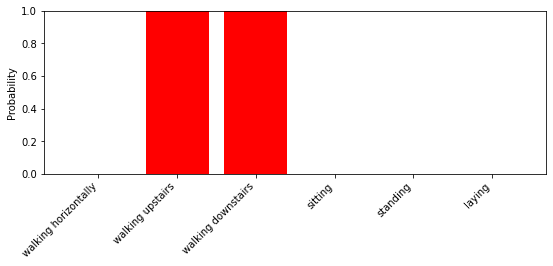

In [271]:
analyse_model_predictions(image_num=1137)
analyse_model_predictions_prob(image_num=1137)

------------------------------
Accelerometer data:


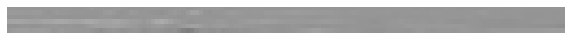

------------------------------
True activity: sitting

------------------------------
Model estimated probabilities:
tf.Tensor(
[[1.4302245e-27 1.5025950e-27 2.1279788e-30 1.2211872e-07 9.9999988e-01
  5.4264066e-21]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


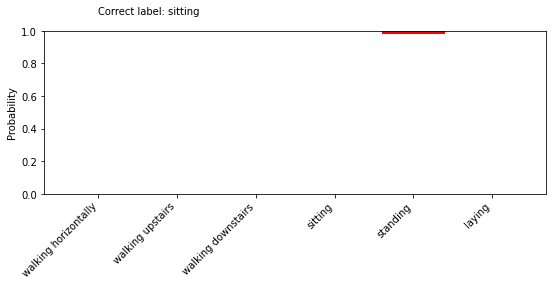

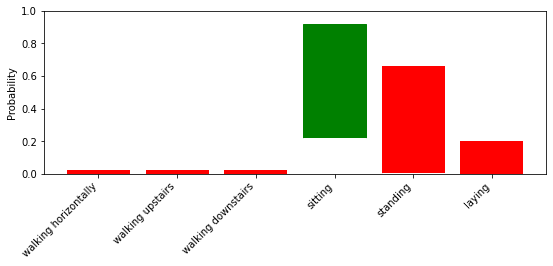

In [272]:
analyse_model_predictions(image_num=511)
analyse_model_predictions_prob(image_num=511)

------------------------------
Accelerometer data:


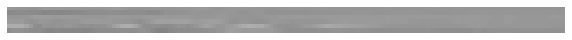

------------------------------
True activity: sitting

------------------------------
Model estimated probabilities:
tf.Tensor(
[[3.8572029e-28 1.2861857e-25 8.1930809e-31 1.0000000e+00 1.0987117e-09
  2.8031953e-11]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


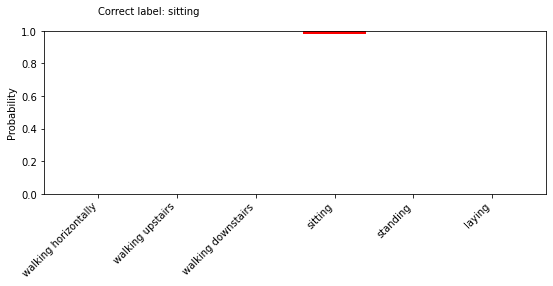

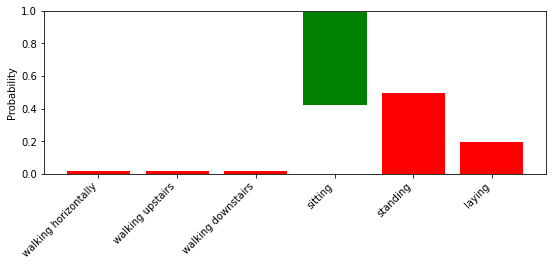

In [273]:
analyse_model_predictions(image_num=1888)
analyse_model_predictions_prob(image_num=1888)

------------------------------
Accelerometer data:


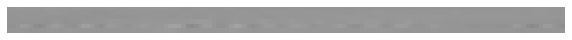

------------------------------
True activity: laying

------------------------------
Model estimated probabilities:
tf.Tensor(
[[1.8484618e-22 1.2153543e-20 2.9609477e-25 9.9988592e-01 5.3929557e-07
  1.1353944e-04]], shape=(1, 6), dtype=float32)


/var/folders/vf/5n8g0z2n3rngl6zxbtg87x3r0000gn/T/ipykernel_60779/2155698329.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],


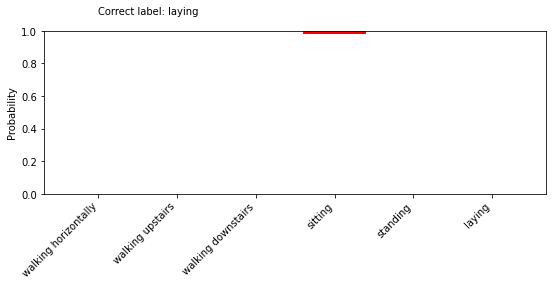

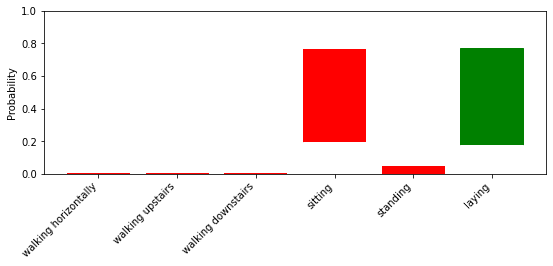

In [278]:
analyse_model_predictions(image_num=1125)
analyse_model_predictions_prob(image_num=1125)